A standalone notebook with text explanations is located in the OpenDP repo:
https://github.com/opendp/opendp/blob/816b171780043dae976dae0481946ceb4c319ec9/python/example/attack_reconstruction.ipynb

In [ ]:
from hw2_starter import *

In [ ]:
# Problem 1.a
def reconstruction_attack(data_pub, predicates, answers):
    masks = np.stack([pred(data_pub) for pred in predicates])
    return np.linalg.lstsq(masks, answers, rcond=None)[0] > 0.5

# Problem 1.a ALT
# def reconstruction_attack(data_pub, predicates, answers):
#     from scipy.optimize import lsq_linear
#     masks = np.stack([pred(data_pub) for pred in predicates])
#     return lsq_linear(masks, answers, bounds=(0, 1)).x > 0.5

# Problem 1.a ALT
# def reconstruction_attack(data_pub, predicates, answers, intercept):
#     from sklearn.linear_model import LinearRegression
#     masks = np.stack([pred(data_pub) for pred in predicates])
#     return LinearRegression(fit_intercept=intercept).fit(masks, answers).coef_

# Problem 1.a ALT (not ideal, as lstsq is more efficient and more numerically stable than pinv)
# def reconstruction_attack(data_pub, predicates, answers):
#     masks = np.stack([pred(data_pub) for pred in predicates])
#     reconstructed = np.linalg.pinv(masks) @ answers
#     return reconstructed > 0.5

predicates = [make_random_predicate() for _ in range(2 * len(data))]
exact_answers = execute_subsetsums_exact(predicates)

# generate example predicates and compute example query answers
reconstructed_target = reconstruction_attack(
    data_pub=data[pub], predicates=predicates, answers=exact_answers)

# complete reconstruction of the target column
assert np.array_equal(reconstructed_target, data[target])

In [ ]:
# Problem 1.b.i
def execute_subsetsums_round(r, predicates):
    return (execute_subsetsums_exact(predicates) / r).round() * r


# Problem 1.b.ii
def execute_subsetsums_noise(sigma, predicates):
    return np.random.normal(
        execute_subsetsums_exact(predicates), 
        scale=sigma, size=exact_answers.shape)


# Problem 1.b.iii
def execute_subsetsums_sample(t, predicates):
    sub_data = data.sample(t)
    mask = np.stack([pred(sub_data) for pred in predicates], axis=1)
    return sub_data[target].values @ mask * len(data) / t


# Problem 1.c.i
def compute_accuracy_reconstruction(reconstructed):
    return (reconstructed == data[target]).mean()


def compute_rmse_answers(answers):
    return np.sqrt(np.mean((answers - exact_answers) ** 2))


# Problem 1.c.ii
interfaces = {
    "round": execute_subsetsums_round,
    "noise": execute_subsetsums_noise,
    "sample": execute_subsetsums_sample
}


def evaluate_performance(interface_name, param):
    predicates_temp = [make_random_predicate() for _ in range(2 * len(data))]
    answers = interfaces[interface_name](param, predicates_temp)
    reconstruction = reconstruction_attack(data[pub], predicates_temp, answers)
    return {
        "interface": interface_name,
        "param": param,
        "answer rmse": compute_rmse_answers(answers),
        "reconstruction accuracy": compute_accuracy_reconstruction(reconstruction),
    }


In [ ]:
perf = evaluate_performance("round", param=20)
print(f'When rounding answers to the nearest multiple of {perf["param"]}, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')
        
perf = evaluate_performance("round", param=40)
print(f'When rounding answers to the nearest multiple of {perf["param"]}, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')

perf = evaluate_performance("noise", param=2.)
print(f'When noising answers with gaussian sigma of {perf["param"]}, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')

perf = evaluate_performance("sample", param=10)
print(f'When sampling to {perf["param"]} rows and then correcting for bias, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')

When rounding answers to the nearest multiple of 20, RMSE of answers is 3.257, and 54.00% of entries were reconstructed.
When rounding answers to the nearest multiple of 40, RMSE of answers is 20.19, and 75.00% of entries were reconstructed.
When noising answers with gaussian sigma of 2.0, RMSE of answers is 5.011, and 97.00% of entries were reconstructed.
When sampling to 10 rows and then correcting for bias, RMSE of answers is 16.07, and 66.00% of entries were reconstructed.


In [ ]:
def evaluate_all_performances(num_trials=10):
    losses = []
    for interface_name in interfaces:
        print("Evaluating", interface_name)
        for param in range(1, len(data) + 1, 5):
            for _ in range(num_trials):
                losses.append(evaluate_performance(interface_name, param))
    return pd.DataFrame(losses)


all_perf = evaluate_all_performances().groupby(["interface", "param"]).mean()

Evaluating round
Evaluating noise
Evaluating sample


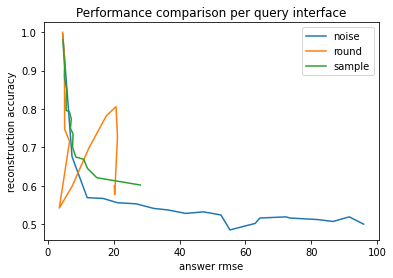

In [ ]:
import matplotlib.pyplot as plt
for name, perf in all_perf.groupby("interface"):
    plt.plot(perf['answer rmse'], perf['reconstruction accuracy'], label=name)

plt.legend()
plt.title("Performance comparison per query interface")
plt.xlabel("answer rmse")
plt.ylabel("reconstruction accuracy")

plt.show()

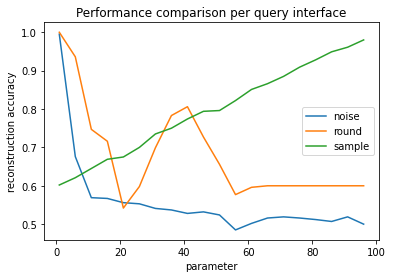

In [ ]:
for name, perf in all_perf.groupby("interface"):
    perf.reset_index(inplace=True)
    plt.plot(perf['param'], perf['reconstruction accuracy'], label=name)

plt.legend()
plt.title("Performance comparison per query interface")
plt.xlabel("parameter")
plt.ylabel("reconstruction accuracy")

plt.show()

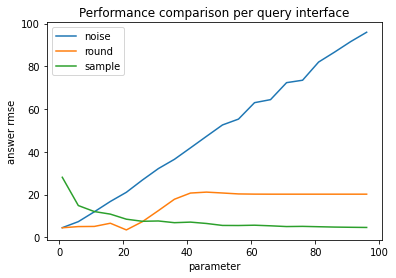

In [ ]:
for name, perf in all_perf.groupby("interface"):
    perf.reset_index(inplace=True)
    plt.plot(perf['param'], perf['answer rmse'], label=name)

plt.legend()
plt.title("Performance comparison per query interface")
plt.xlabel("parameter")
plt.ylabel("answer rmse")

plt.show()